In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import hamming_loss, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import NuSVR

np.random.seed(0)

In [2]:
# 데이터 생성 함수: 회귀와 분류를 위한 데이터 생성
def generate_data(case):
    if case == "regression":
        X, y = datasets.load_diabetes(return_X_y=True)
        train_size = 0.8
    elif case == "classification":
        X, y = datasets.fetch_20newsgroups_vectorized(subset="all", return_X_y=True)
        train_size = 0.4  # to make the example run faster

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=0
    )

    data = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
    return data


regression_data = generate_data("regression")
classification_data = generate_data("classification")

In [3]:
# 벤치마킹 함수: 모델 복잡성에 따른 성능과 예측 시간 측정
def benchmark_influence(conf):
    prediction_times = []
    prediction_powers = []
    complexities = []
    for param_value in conf["changing_param_values"]:
        conf["tuned_params"][conf["changing_param"]] = param_value
        estimator = conf["estimator"](**conf["tuned_params"])

        print("Benchmarking %s" % estimator)
        estimator.fit(conf["data"]["X_train"], conf["data"]["y_train"])
        conf["postfit_hook"](estimator)
        complexity = conf["complexity_computer"](estimator)
        complexities.append(complexity)
        start_time = time.time()
        for _ in range(conf["n_samples"]):
            y_pred = estimator.predict(conf["data"]["X_test"])
        elapsed_time = (time.time() - start_time) / float(conf["n_samples"])
        prediction_times.append(elapsed_time)
        pred_score = conf["prediction_performance_computer"](
            conf["data"]["y_test"], y_pred
        )
        prediction_powers.append(pred_score)
        print(
            "Complexity: %d | %s: %.4f | Pred. Time: %fs\n"
            % (
                complexity,
                conf["prediction_performance_label"],
                pred_score,
                elapsed_time,
            )
        )
    return prediction_powers, prediction_times, complexities

In [4]:
# 모델 복잡성 계산을 위한 함수 (예: 비제로 계수 개수, 서포트 벡터 개수)
def _count_nonzero_coefficients(estimator):
    a = estimator.coef_.toarray()
    return np.count_nonzero(a)


configurations = [
    {
        "estimator": SGDClassifier,
        "tuned_params": {
            "penalty": "elasticnet",
            "alpha": 0.001,
            "loss": "modified_huber",
            "fit_intercept": True,
            "tol": 1e-1,
            "n_iter_no_change": 2,
        },
        "changing_param": "l1_ratio",
        "changing_param_values": [0.25, 0.5, 0.75, 0.9],
        "complexity_label": "non_zero coefficients",
        "complexity_computer": _count_nonzero_coefficients,
        "prediction_performance_computer": hamming_loss,
        "prediction_performance_label": "Hamming Loss (Misclassification Ratio)",
        "postfit_hook": lambda x: x.sparsify(),
        "data": classification_data,
        "n_samples": 5,
    },
    {
        "estimator": NuSVR,
        "tuned_params": {"C": 1e3, "gamma": 2**-15},
        "changing_param": "nu",
        "changing_param_values": [0.05, 0.1, 0.2, 0.35, 0.5],
        "complexity_label": "n_support_vectors",
        "complexity_computer": lambda x: len(x.support_vectors_),
        "data": regression_data,
        "postfit_hook": lambda x: x,
        "prediction_performance_computer": mean_squared_error,
        "prediction_performance_label": "MSE",
        "n_samples": 15,
    },
    {
        "estimator": GradientBoostingRegressor,
        "tuned_params": {
            "loss": "squared_error",
            "learning_rate": 0.05,
            "max_depth": 2,
        },
        "changing_param": "n_estimators",
        "changing_param_values": [10, 25, 50, 75, 100],
        "complexity_label": "n_trees",
        "complexity_computer": lambda x: x.n_estimators,
        "data": regression_data,
        "postfit_hook": lambda x: x,
        "prediction_performance_computer": mean_squared_error,
        "prediction_performance_label": "MSE",
        "n_samples": 15,
    },
]

Benchmarking SGDClassifier(alpha=0.001, l1_ratio=0.25, loss='modified_huber',
              n_iter_no_change=2, penalty='elasticnet', tol=0.1)
Complexity: 4887 | Hamming Loss (Misclassification Ratio): 0.2780 | Pred. Time: 0.059573s

Benchmarking SGDClassifier(alpha=0.001, l1_ratio=0.5, loss='modified_huber',
              n_iter_no_change=2, penalty='elasticnet', tol=0.1)
Complexity: 1851 | Hamming Loss (Misclassification Ratio): 0.3185 | Pred. Time: 0.043013s

Benchmarking SGDClassifier(alpha=0.001, l1_ratio=0.75, loss='modified_huber',
              n_iter_no_change=2, penalty='elasticnet', tol=0.1)
Complexity: 1012 | Hamming Loss (Misclassification Ratio): 0.3381 | Pred. Time: 0.034168s

Benchmarking SGDClassifier(alpha=0.001, l1_ratio=0.9, loss='modified_huber',
              n_iter_no_change=2, penalty='elasticnet', tol=0.1)
Complexity: 805 | Hamming Loss (Misclassification Ratio): 0.3464 | Pred. Time: 0.031256s

Benchmarking NuSVR(C=1000.0, gamma=3.0517578125e-05, nu=0.05)
Compl

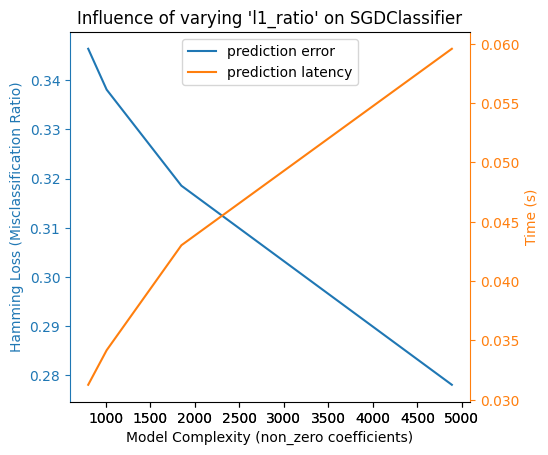

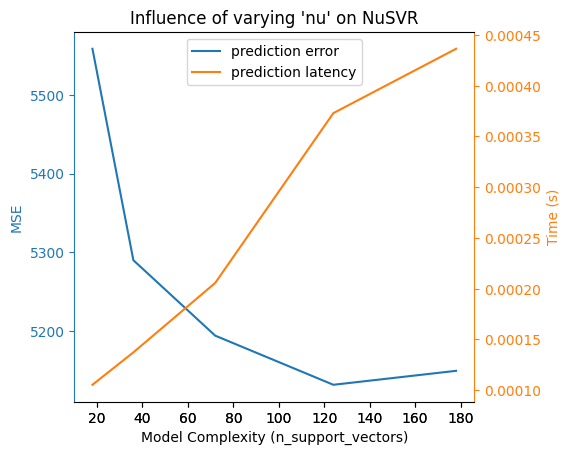

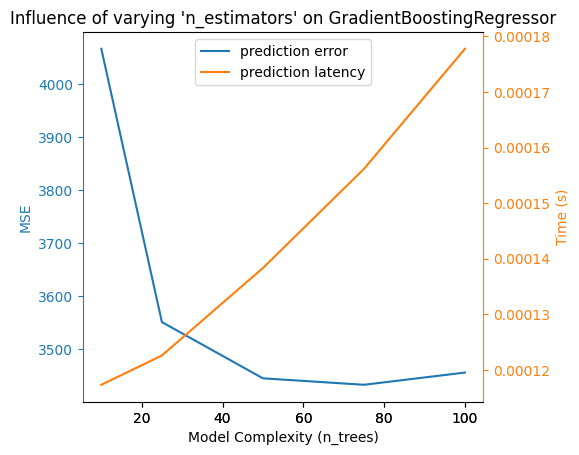

In [6]:
# 영향을 시각화하는 함수: 모델 복잡성과 예측 성능의 관계를 플롯으로 나타냄
def plot_influence(conf, mse_values, prediction_times, complexities):
    """
    Plot influence of model complexity on both accuracy and latency.
    """

    fig = plt.figure()
    fig.subplots_adjust(right=0.75)

    # first axes (prediction error)
    ax1 = fig.add_subplot(111)
    line1 = ax1.plot(complexities, mse_values, c="tab:blue", ls="-")[0]
    ax1.set_xlabel("Model Complexity (%s)" % conf["complexity_label"])
    y1_label = conf["prediction_performance_label"]
    ax1.set_ylabel(y1_label)

    ax1.spines["left"].set_color(line1.get_color())
    ax1.yaxis.label.set_color(line1.get_color())
    ax1.tick_params(axis="y", colors=line1.get_color())

    # second axes (latency)
    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    line2 = ax2.plot(complexities, prediction_times, c="tab:orange", ls="-")[0]
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    y2_label = "Time (s)"
    ax2.set_ylabel(y2_label)
    ax1.spines["right"].set_color(line2.get_color())
    ax2.yaxis.label.set_color(line2.get_color())
    ax2.tick_params(axis="y", colors=line2.get_color())

    plt.legend(
        (line1, line2), ("prediction error", "prediction latency"), loc="upper center"
    )

    plt.title(
        "Influence of varying '%s' on %s"
        % (conf["changing_param"], conf["estimator"].__name__)
    )

# 각 구성에 대해 벤치마킹 수행 및 시각화
for conf in configurations:
    prediction_performances, prediction_times, complexities = benchmark_influence(conf)
    plot_influence(conf, prediction_performances, prediction_times, complexities)
plt.show()